In [15]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
cos = nn.CosineSimilarity(dim=0, eps=1e-9)
from torchvision import transforms
# from codes.models import ConvNet, resnet8, MLP
from utils import *
from torch.utils.data import DataLoader
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
device = "cuda"

# adjustable parameters
alpha_d = 1.0
local_ep = 1
points = 41
attack ="tlp" #"bd"
model_name = "ConvNet" # "resnet8"
num_classes = 10
dataset ="fmnist"

In [ ]:

def get_delta_cos(model1, model2, model0_sd):
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader):
    acc = eval_op_ensemble([model], test_loader)
    asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    return list(acc.values())[0], list(asr.values())[0]


def sample_and_replace(model1, model2, model3, k_percent):
    """
    Randomly selects k% of parameters within each layer from model2 and replaces them in model1.
    Returns a new model (model3) with mixed parameters and a dictionary of replaced indices.
    """
    model3.load_state_dict(model1.state_dict())  # Start with model1's parameters
    replaced_params = {}
    
    state_dict = model3.state_dict()
    for param_name in model1.state_dict().keys():
        param1 = model1.state_dict()[param_name]
        param2 = model2.state_dict()[param_name]
        num_elements = param1.numel()
        num_replace = int((k_percent / 100) * num_elements)
        
        if num_replace > 0:
            indices = random.sample(range(num_elements), num_replace)
            param1.view(-1)[indices] = param2.view(-1)[indices]
            param1_flat = param1.view(-1)
            param2_flat = param2.view(-1)
            param1_flat[indices] = param2_flat[indices]
            state_dict[param_name] = param1.view(param1.shape)
            replaced_params[param_name] = indices
    
    model3.load_state_dict(state_dict)
    return model3, replaced_params




def sampling_experiment(model1, model2, model3, model0_sd, main_dataloader, device, k_percent, p):
    """
    Runs p sampling experiments, evaluates model3 on both main and side tasks.
    """
    results = {}
    replaced_params_list=[]
    for i in range(p):
        model3.load_state_dict(model1.state_dict())
        model3, replaced_params = sample_and_replace(model1, model2, model3, k_percent)
        acc_, asr_  = model_eval(model3, main_dataloader)
        delta, cos_dist = get_delta_cos(model1, model3, model0_sd)
        results[i] = (acc_, asr_, cos_dist)
        replaced_params_list.append({asr_:  replaced_params})
    return results, replaced_params_list


def replaced_params_count(replaced_params_list):
    """
    Counts occurrences of values per layer across multiple replaced_params dictionaries.

    :param replaced_params_list: List of replaced_params dictionaries.
    :return: Dictionary where keys are layer names and values are Counters of occurrences.
    """
    layer_counts = {}

    for replaced_params in replaced_params_list:
        for layer, values in replaced_params.items():
            if layer not in layer_counts:
                layer_counts[layer] = Counter()
            layer_counts[layer].update(values)

    return layer_counts


def convert_to_state_dict(layer_counts, state_dict):
    ind_w = OrderedDict()
    
    # Iterate over the outer dictionary (float keys)
    for weight, layers in layer_counts.items():
        for layer_name, indices in layers.items():
            print("layer_name", layer_name, indices)
            # If the layer is not in state_dict, initialize it with an empty list of zeros
            if layer_name not in ind_w:
                ind_w[layer_name] = {}
            
            for index in range(state_dict[layer_name].numel()):  
                if index in indices:
                    # Add the weight to the corresponding index in the layer
                    if index not in ind_w[layer_name]:
                        ind_w[layer_name][index] = 0
                    ind_w[layer_name][index] += weight
                else:
                    # other not selected indices
                    ind_w[layer_name][index] = 0
            
    
    # print("ind_w keys", ind_w.keys())
    # print("state_dict keys", state_dict.keys())
    
    for name, asr_dict in ind_w.items():
        asr_w = torch.tensor([value for key, value in sorted(asr_dict.items())])
        print(f"name:{name}, asr_w:{asr_w.numel()}, state_dict:{state_dict[name].numel()}")
        state_dict[name] = asr_w.view(state_dict[name].shape)
    
    return state_dict


def plot_layer_weights(layer_name, params, title, save_plot=False):
    """
    Plots the weights of a specific layer in a PyTorch model as a heatmap.
    
    Parameters:
        layer (torch.nn.Module): The PyTorch layer (e.g., torch.nn.Linear, torch.nn.Conv2d).
        layer_name (str): A text string to label the plot and use in the filename.
        save_plot (bool): If True, saves the plot as a PNG file with the layer_name as part of the filename.
    """
    # Check if the layer has weights
    # if not hasattr(layer, 'weight'):
    #     raise ValueError(f"The provided layer does not have weights.")
    
    # Extract the weights
    params = params.reshape(params.size(0), -1)
    
    weights = params.cpu().numpy()
    
    # Plot the weights as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(weights, cmap="coolwarm", annot=False, cbar=True)
    plt.title(f'Weight Matrix of {layer_name} _ {title}')
    plt.xlabel('Neuron Index')
    plt.ylabel('Input Index')
    
    if save_plot:
        # Save the plot with the layer_name as part of the filename
        filename = f"{layer_name}_{title}_weights_heatmap.png"
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        print(f"Plot saved as {filename}")
    
    plt.show()

In [17]:
# adjustable parameters
alpha_d = 1.0
local_ep = 1
points = 41
attack ="tlp" #"bd"
model_name = "ConvNet" # "resnet8"
num_classes = 10
dataset ="fmnist"

# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

# Load the training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load the test dataset
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batch processing
client_loaders, test_loader, client_data_subsets =\
    data.get_loaders(train_data, test_data, n_clients=100,
                    alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)
    
model_fn = partial(models.get_model(model_name)[
                        0], num_classes=num_classes, dataset=dataset)

client_loader = client_loaders[0]

# created models
model1 = model_fn().to(device)
model2 = model_fn().to(device)
model3 = model_fn().to(device)

model0_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}

optimizer1 = optim.SGD(model1.parameters(), lr=0.001)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)
optimizer3 = optim.SGD(model3.parameters(), lr=0.001)


Data split:
 - Client 0: [226  18  19  79  27 116  25   3  35  47]               -> sum=595
 - Client 1: [ 86  54   6  41   2  98 160 128   4  20]               -> sum=599
 - Client 2: [150  21  89  25   3  55  60 178   2  19]               -> sum=602
 - Client 3: [ 59 103  22 131 163   9  28  29   2  53]               -> sum=599
 - Client 4: [ 61 185  28  97  35  54  23   9   2 106]               -> sum=600
 - Client 5: [ 17  64  24  20  10 229 121  28  24  63]               -> sum=600
 - Client 6: [232   5   9  30   7 123   7  20  93  75]               -> sum=601
 - Client 7: [  0  71  38  46  45  74   1  81 155  87]               -> sum=598
 - Client 8: [ 22  79  22   9  83 138  50  82  37  79]               -> sum=601
 - Client 9: [29 83 47 76 98 26 25 55 72 89]                         -> sum=600
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 91: [ 18  44  49  84  21  49 141  47  83  62]               -> sum=598
 - Client 92: 

In [ ]:
train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)

# model2 train from model1
model2.load_state_dict(model1.state_dict())
train_op_tr_flip(model2, client_loader, optimizer2, epochs=local_ep, class_num=10, print_train_loss=True)

acc1, asr1 = model_eval(model1, test_loader)
acc2, asr2 = model_eval(model2, test_loader)

# delta, org_cos
delta0, org_cos2 = get_delta_cos(model1, model2, model0_sd)
print(f"model1 acc:{acc1}, asr:{asr1}, cos dist:{0}")
print(f"model2 acc:{acc2}, asr:{asr2}, cos dist:{org_cos2}")

results, replaced_params_list = sampling_experiment(model1, model2, model3, model0_sd, client_loader, device, k_percent=50, p=4)

print("results:\n", results)

layer_counts = replaced_params_count(replaced_params_list)

print("layer_counts", layer_counts)

state_dict = convert_to_state_dict(layer_counts, model3.state_dict())
model3.load_state_dict(state_dict)
torch.save(model3.state_dict(), 'model3_sd.pth')

[2.28, 2.09, 1.93, 1.81, 1.72, 1.65, 1.59, 1.55, 1.51, 1.48]
[2.35, 1.88, 1.89, 1.72, 1.48, 1.37, 1.6, 1.33, 1.37, 1.28]
model1 acc:0.1995, asr:0.0, cos dist:0
model2 acc:0.2353, asr:0.98, cos dist:0.41374683380126953
results:
 {0: (0.6336134453781512, 0.061946902654867256, 0.0), 1: (0.28739495798319326, 0.9557522123893806, 0.0), 2: (0.2672268907563025, 0.9690265486725663, 0.0), 3: (0.2605042016806723, 0.9690265486725663, 0.0)}
layer_counts {0.061946902654867256: Counter({'features.8.weight': [117105, 51815, 21279, 98568, 35892, 9020, 6702, 52724, 78735, 59928, 92984, 88083, 77619, 131554, 25008, 14729, 132870, 7353, 14142, 93231, 62057, 6558, 96786, 11224, 35718, 35836, 82990, 41053, 65611, 9250, 60622, 89595, 73113, 57948, 18511, 93375, 79882, 10099, 13102, 15501, 109465, 90796, 6502, 6856, 82231, 72212, 90401, 105317, 72784, 87644, 5109, 72214, 134905, 59374, 6573, 33412, 64908, 144045, 58674, 74082, 22416, 3480, 60479, 75066, 37617, 53295, 111328, 143612, 43404, 129946, 138145, 900

Plot saved as features.0.weight_weights_heatmap.png


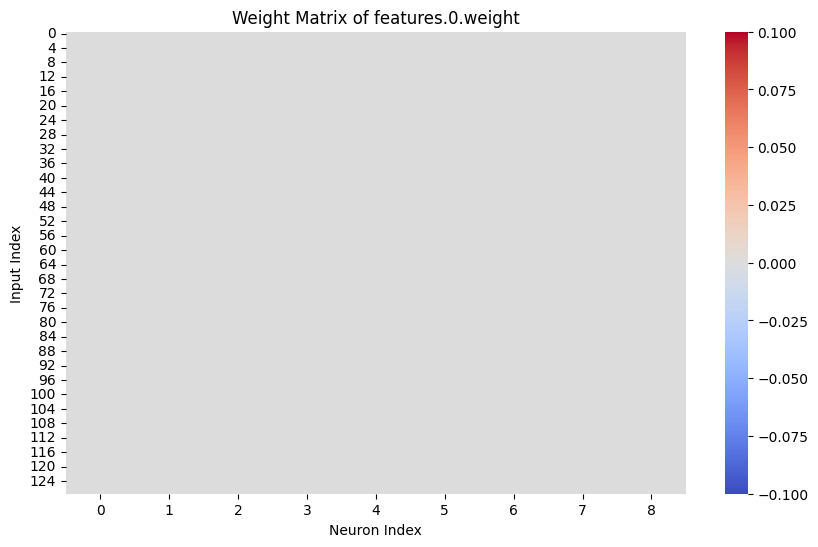

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        ...,


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])

In [ ]:
for name, params in state_dict.items():
    plot_layer_weights(name, state_dict[name], title="k=50", save_plot=True)